Load dependency Python Packages

In [1]:
from py2neo import Graph, Node, Relationship,authenticate
import numpy as np
import pandas as pd
from datetime import datetime
# from py2neo.server import GraphServer

Configuration of Graph Database

In [3]:
# set up authentication parameters
authenticate("localhost:7474", "neo4j", "admin")

# connect to authenticated graph database
graph = Graph("http://localhost:7474/db/data/")
# grapp = Gp_dfraph()

Load Patient and Admission Dataset.

In [4]:
patients = pd.read_csv('../doh/mimic3/data/PATIENTS.csv')
admissions = pd.read_csv('../doh/mimic3/data/ADMISSIONS.csv')

Get Unique Patients and Generate patient profiles.

In [5]:
unique_pats = admissions.SUBJECT_ID.unique()
profs = pd.merge(admissions,patients,how='left',on='SUBJECT_ID').\
            drop(['ROW_ID_y','ROW_ID_x','DOB','DOD','DOD_HOSP','DOD_SSN','EXPIRE_FLAG'], axis=1)

In [5]:
profs.shape,  admissions.shape,unique_pats.shape

((58976, 19), (58976, 19), (46520,))

In [6]:
profs.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,F
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,M
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,M
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,M


Group patients' activities accourding to SUBJECT_ID, and Sample 10000 patients to do experiment.

In [7]:
grouped = profs.groupby(['SUBJECT_ID'])
samples = unique_pats[range(10000)]

Add nodes and relationships to Graph.

The first for loop is to get patients' latest information as their demographic data and create "patient" nodes to add into graph.

The second for loop is to extract patients' sequence of activities, create "Acitvity" nodes and "Hospital" relationships to add into graph.

In [ ]:
tx = graph.begin()
# for sub_id in unique_pats[0:1000]:
for sub_id in samples:
    pat_acts = grouped.get_group(sub_id).sort_values(by=['ADMITTIME'])
    last_act = pat_acts.tail(1)
    p = Node("Patient", \
             pid=str(last_act.SUBJECT_ID.values[0]),\
             insurance=last_act.INSURANCE.values[0],\
             religion=last_act.RELIGION.values[0],\
             marital=last_act.MARITAL_STATUS.values[0],\
             ethnicity=last_act.ETHNICITY.values[0],\
             gender=last_act.GENDER.values[0])
    tx.create(p)
    
    for index, row in pat_acts.iterrows():
        act = Node("Activity", \
                   hadm=row['HADM_ID'],\
                   admit_time=row['ADMITTIME'],\
                   disch_time=row['DISCHTIME'],\
                   admit_type=row['ADMISSION_TYPE'],\
                   admit_loc=row['ADMISSION_LOCATION'],\
                   disch_loc=row['DISCHARGE_LOCATION'],\
                   diag=row['DIAGNOSIS'])
        tx.create(act)
        hsp = Relationship(p, "Hospital", act)
        tx.create(hsp)
        p = act
tx.commit()   


In [8]:
#Create a new pandas dataframe only including patient ID
df = pd.DataFrame(samples,columns=['pid'])

Only extract activies in patient journey. And add returnd data from each graph path into dataframe DF.

In [9]:
#list of admission types
adm_type = ['EMERGENCY','ELECTIVE','NEWBORN','URGENT']
path_range = range(1,5) #path range from 1 to 4
for l in path_range: 
    for adm in adm_type:
        p = "MATCH (n:Patient)-[:Hospital*"+str(l)+"]->(act) WHERE act.admit_type='"\
                + adm +"' RETURN n.pid as pid, 1 as path_"+str(l)+"_"+adm
        
        graphData = graph.data(p)
        if(len(graphData)>0):
            p_df = pd.DataFrame(graphData)
            p_df.pid = p_df.pid.astype(int)
            df = pd.merge(df,p_df,on='pid',how='left')
df = df.fillna(0)

In [10]:
df.head()

,pid,path_1_EMERGENCY,path_1_ELECTIVE,path_1_NEWBORN,path_1_URGENT,path_2_EMERGENCY,path_2_ELECTIVE,path_2_NEWBORN,path_2_URGENT,path_3_EMERGENCY,path_3_ELECTIVE,path_3_NEWBORN,path_3_URGENT,path_4_EMERGENCY,path_4_ELECTIVE,path_4_URGENT
0,22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Only extract days difference between two chronological activies in patient journey. And add returnd data from each graph path into dataframe DF.

In [11]:
#list of admission types
adm_type = ['EMERGENCY','ELECTIVE','NEWBORN','URGENT']
path_range = range(1,4) #path range from 1 to 4
for l in path_range: 
    for adm in adm_type:
        p = "MATCH (n:Patient)-[:Hospital*"+str(l)+"]->(act1)-[:Hospital]->(act2)"\
           +"WITH n,act1,act2,split(act1.admit_time, ' ') AS adm_d1,split(act2.admit_time, ' ') AS adm_d2 "\
           +"WHERE act2.admit_type='"+ adm +"' RETURN n.pid as pid, "\
           +"adm_d2[0] as next_date,adm_d1[0] as pre_date"
        g_data = graph.data(p)
        if(len(g_data)>0):
            time_df = pd.DataFrame(g_data)
            time_df['days_diff_'+str(l+1)+'_'+adm] = (pd.to_datetime(time_df.next_date) 
                                                     - pd.to_datetime(time_df.pre_date)).dt.days
            time_df = time_df.drop(columns=["pre_date",'next_date'],axis=1)

            time_df.pid = time_df.pid.astype(int)
            df = pd.merge(df,time_df,on='pid',how='left')
df = df.fillna(0)

In [ ]:
df.to_csv('path_daydiff_10000.csv',index=False)

In [12]:
pid = df.pid
final_df = df.drop(columns=['pid'],axis=1)

Normalize final dataset.

In [13]:
from sklearn.preprocessing import StandardScaler
data_fe = StandardScaler().fit_transform(df)

In [14]:
norm_df = pd.DataFrame(data_fe)

Determine optimal cluster number of k.

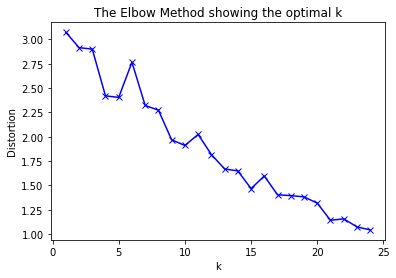

In [15]:
# clustering dataset
# determine k using elbow method
 
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

 
# create new plot and data
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
 
# k means determine k
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=42).fit(norm_df)
#     kmeanModel.fit(data)
    distortions.append(sum(np.min(cdist(norm_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / norm_df.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [16]:
from sklearn.cluster import KMeans
n_clusters = 5
kmeanModel = KMeans(n_clusters=n_clusters,random_state=42).fit(norm_df)
# kmeanModel.fit(data)

In [17]:
clusters = pd.DataFrame(kmeanModel.labels_,columns=['label'])

In [18]:
for i in range(n_clusters):
    print('label:' + str(i),clusters[clusters.label==i].count())

label:0 label    5328
dtype: int64
label:1 label    1
dtype: int64
label:2 label    1
dtype: int64
label:3 label    4143
dtype: int64
label:4 label    527
dtype: int64


In [ ]:
import seaborn as sns
for c in range(n_clusters):
    plt.figure(c,figsize=(15,35))
    plt.suptitle("Cluter "+str(c),fontsize=16)
    ds = final_df[final_df.label == c]
    ds = ds.drop(columns=['label'],axis=1)
    for i, col in enumerate(ds.columns):
        plt.subplot(9,3,i+1)
        sns.distplot(ds[col],kde=False)

In [19]:
import json, urllib
# import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [20]:
#generating labals        
path_range = range(0,4)
labelsDic = {}
for l in path_range: 
    for ind, adm in enumerate(adm_type):
        labelsDic[l*len(adm_type)+ind+1] = adm

        
pat_clusters = pd.concat([pid,clusters.label],axis=1)

for c in range(n_clusters):
    pat_per_cluster = pat_clusters[pat_clusters.label==c].pid.tolist()
    pat_per_cluster_str = "','".join(str(x) for x in pat_per_cluster)
    pat_per_cluster_str = "['" + pat_per_cluster_str + "']"

    #list of admission types
    adm_type = ['EMERGENCY','ELECTIVE','NEWBORN','URGENT']
    path_range = range(0,4) #path range from 1 to 4
    p_df = pd.DataFrame(columns=['count','source','target'])
    for l in path_range: 
        if(l == 0):
            for indx1,adm1 in enumerate(adm_type):
                p = "MATCH (n:Patient)-[:Hospital*1]->(act1:Activity) WHERE act1.admit_type='"\
                        + adm1 +"' AND n.pid IN "+ pat_per_cluster_str +" RETURN \
                        count(n) as count,0 as source, "+ str(indx1+l*4+1) +" as target"
                graphData = graph.data(p) 
                #         print(p)
                if(len(graphData)>0):
                    p_df = pd.concat([p_df,pd.DataFrame(graphData)],axis=0)
                else:
                    temp_data = [{'count':0,'source':0,'target': indx1+l*4+1}]
                    p_df = pd.concat([p_df,pd.DataFrame(temp_data)],axis=0)
        else:
            for indx1,adm1 in enumerate(adm_type):
                for indx2, adm2 in enumerate(adm_type):
                    p = "MATCH (n:Patient)-[:Hospital*"+str(l)+"]->(act1:Activity)-[:Hospital]->(act2) WHERE act1.admit_type='"\
                            + adm1 +"' AND act2.admit_type='" + adm2 +"' AND n.pid IN "+ pat_per_cluster_str +" RETURN \
                            count(n) as count," + str(indx1+(l-1)*4+1) +" as source, "+str(indx2+l*4+1) +" as target"

                    graphData = graph.data(p) 
                #         print(p)
                    if(len(graphData)>0):
                        p_df = pd.concat([p_df,pd.DataFrame(graphData)],axis=0)
                    else:
                        temp_data = [{'count':0,'source':indx1+(l-1)*4+1 ,'target': indx2+(l)*4+1}]
                        p_df = pd.concat([p_df,pd.DataFrame(temp_data)],axis=0)
    p_df = p_df.fillna(0)
    p_df = p_df[p_df['count']>0]
    
    labelList = sorted(p_df.target.unique())
    labels = ['#Patients']
    for indx, label in enumerate(labelList):
        labels.append(labelsDic[label])
        p_df.loc[p_df['source'] == label, 'source'] = indx + 1
        p_df.loc[p_df['target'] == label, 'target'] = indx + 1
    p_df = p_df.reset_index()
#     print(p_df)
#     p_df.loc[range(0,len(labels)),'labels'] = labels
     
    #plot sankey diagram for each cluster
    data_trace = dict(
        type='sankey',
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 10,
          thickness = 30,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label =  labels,
    #       color = refugee_df['Color']
        ),
        link = dict(
          source = p_df['source'].dropna(axis=0, how='any'),
          target = p_df['target'].dropna(axis=0, how='any'),
          value = p_df['count'].dropna(axis=0, how='any'),
      )
    )

    layout =  dict(
        title = "Patient Journey",
        height = 772,
        width = 950,
        font = dict(
          size = 10
        ),    
    )


    fig = dict(data=[data_trace], layout=layout)
    iplot(fig, validate=False)
    p_df.drop(p_df.index, inplace=True)
    
#     plot(fig, filename = 'cluster_'+str(c)+'.html', output_type='file',show_link=False,
#                                       auto_open=False,include_plotlyjs=True)